In [380]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage()
transform = transforms.Compose(
    [transforms.ToTensor(), # numpy -> Tensor
     transforms.Normalize((0.5,), (0.5,))])# 归一化

In [381]:
batch_Size = 300
Num_workers = 16
trainset = torchvision.datasets.FashionMNIST(root='./data/fashiopn', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_Size,
                                          shuffle=True, num_workers=Num_workers, pin_memory=True)
print(len(trainloader))
testset = torchvision.datasets.FashionMNIST(root='./data/fashiopn', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_Size,
                                         shuffle=False, num_workers=Num_workers, pin_memory=True)
print(len(testloader))

200
34


Sandal


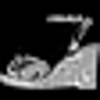

In [382]:
classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress','Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
num = 25
dataiter = iter(trainloader)
images, labels = dataiter.next()
data = images[num]
label = labels[num]
print(classes[label])
show((data + 1) / 2).resize((100,100))


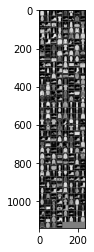

 Coat Trouser Dress Sneaker Shirt T-shirt Sandal Pullover  Coat Trouser Ankle boot T-shirt Sneaker Sandal  Coat Sandal Sandal Ankle boot   Bag Shirt   Bag Trouser   Bag Shirt   Bag Ankle boot Dress Dress   Bag Shirt Pullover Dress Ankle boot Dress Ankle boot Pullover Sneaker Shirt Shirt Pullover Pullover Ankle boot Sandal   Bag Pullover Sandal Sandal T-shirt Sandal Sandal Dress T-shirt T-shirt Sneaker  Coat Trouser   Bag Sneaker Dress   Bag Ankle boot  Coat Shirt Pullover Sneaker   Bag   Bag Pullover Dress  Coat  Coat Sneaker Sandal Sandal Trouser Sneaker  Coat   Bag Sandal   Bag Sneaker Dress Trouser Ankle boot   Bag Sneaker Ankle boot Dress Sneaker Sandal  Coat Ankle boot   Bag Sneaker T-shirt   Bag Trouser   Bag Sneaker  Coat


In [383]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy() # tensor -> numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # 改变通道顺序
    plt.show()
    
# 随机获取数据 --- next（）命令
dataiter = iter(trainloader)
images, labels = dataiter.next()

#显示图片
imshow(torchvision.utils.make_grid(images))
#输出图片标签
print(' '.join('%5s' % classes[labels[j]] for j in range(100)))

In [384]:
"""定义网络"""
# 特征图片尺寸计算公式：{（原始图片尺寸 - 卷积核尺寸）/ 步长} + 1

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷积层1， 输入是28*28*1，计算（ 28 - 5 ）/ 1 + 1 = 24，那么通过conv1输出的结果为24*24*6
        self.conv1 = nn.Conv2d(1, 6, 5)# imput：1，output：6，kernel：5
        
        # 池化层， 输入时24*24*6，窗口2*2，计算24 / 2 = 12，那么通过max_pool层输出的结果是12*12*6
        self.pool = nn.MaxPool2d(2, 2)#  kernel：2，stride：2
        
        # 卷积层2， 输入是14*14*6，计算（ 12 - 5 ）/ 1 + 1 = 8，那么通过conv1输出的结果为8*8*16
        self.conv2 = nn.Conv2d(6, 16, 5) # imput：6，output：16，kernel：5
        
        # 全连接层1 
        self.fc1 = nn.Linear(16 * 4 * 4, 120)# input：16*5*5，output：120
        # 全连接层2 
        self.fc2 = nn.Linear(120, 84)#  input：120，output：84
        # 全连接层3 
        self.fc3 = nn.Linear(84, 10)#  input：84，output：10
        
        # 构造Dropout方法，在每次训练过程中随机“掐死”一部分神经元，防止过拟合
        # self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
       
        # 卷积1  28*28*1 ---> 24*24*6 ---> 12*12*6
        x = self.pool(F.relu(self.conv1(x)))
        
        # 卷积2  12*12*6 ---> 8*8*16 ---> 4*4*16
        x = self.pool(F.relu(self.conv2(x)))
        
        # 改变shape
        x = x.view(x.size()[0],-1)
        # 全连接层1 
        x = F.relu(self.fc1(x))
        # 全连接层2
        x = F.relu(self.fc2(x))
        # 全连接层3 
        x = self.fc3(x)
        
        return x

In [385]:
net = Net().to('cuda')

In [386]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # 交叉式损失函数
# criterion = nn.NLLLoss()# 负对数损失函数

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)# SGD随机梯度下降优化器
# optimizer = optim.Adam(net.parameters(), lr=0.003)# Adam梯度下降优化



In [387]:
"""存放loss的列表"""
train_losses, test_losses = [], []

In [388]:
acc = []
for epoch in range(100):
    train_loss = 0.0
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for i ,(data,labels) in enumerate(trainloader):
        datas, labels = data.to('cuda'), labels.to('cuda')
        # 梯度置零
        optimizer.zero_grad()
        # 训练
        outputs = net(datas)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
        # 累计损失
        train_loss += loss.item()
    train_losses.append(train_loss/len(trainloader.dataset))
    """保存模型"""
    PATH = './cifar_net1.pth'
    torch.save(net.state_dict(), PATH)
    """加载模型"""
    model = Net()
    model.load_state_dict(torch.load(PATH))
    correct = 0
    total = 0
    flag=True

    with torch.no_grad():
        test_loss =0.0
        score_list = []     # 存储预测得分
        label_list = []     # 存储真实标签
        for i ,(data,labels) in enumerate(testloader):
        
            # 输出
            outputs =model(data)# outputs.data.shape --> torch.size([128,10])
            _, predicted = torch.max(outputs.data, dim=1)# 第一个是值的张量，第二个是序号的张量
            # 累计数据量
            total += labels.size(0)# labels.size() --> torch.size([128]), labels.size(0) --> 128
            # 比较有多少个预测正确
            correct += (predicted == labels).sum()
            # 训练误差
            
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            # print(test_loss)
            
            score_tmp = outputs  # (batchsize, nclass)
 
            score_list.extend(score_tmp.detach().cpu().numpy())
            label_list.extend(labels.cpu().numpy())

            
        test_losses.append(test_loss/len(testloader.dataset))
            # print(test_losses)
        
        print("在1000张图片上的准确率：{:.3f}%".format(100 *correct //total ))
        
        print(total)
         
        acc.append(correct/10000.00)
        print(acc)
    print("Epoch: %d , Bath : %5d, Loss : %.3f "%(epoch+1, i+1, train_loss/len(trainloader.dataset)))

在1000张图片上的准确率：11.000%
10000
[tensor(0.1166)]
Epoch: 1 , Bath :    34, Loss : 0.008 
在1000张图片上的准确率：32.000%
10000
[tensor(0.1166), tensor(0.3204)]
Epoch: 2 , Bath :    34, Loss : 0.008 
在1000张图片上的准确率：57.000%
10000
[tensor(0.1166), tensor(0.3204), tensor(0.5725)]
Epoch: 3 , Bath :    34, Loss : 0.007 
在1000张图片上的准确率：69.000%
10000
[tensor(0.1166), tensor(0.3204), tensor(0.5725), tensor(0.6902)]
Epoch: 4 , Bath :    34, Loss : 0.003 
在1000张图片上的准确率：71.000%
10000
[tensor(0.1166), tensor(0.3204), tensor(0.5725), tensor(0.6902), tensor(0.7187)]
Epoch: 5 , Bath :    34, Loss : 0.003 
在1000张图片上的准确率：73.000%
10000
[tensor(0.1166), tensor(0.3204), tensor(0.5725), tensor(0.6902), tensor(0.7187), tensor(0.7304)]
Epoch: 6 , Bath :    34, Loss : 0.002 
在1000张图片上的准确率：73.000%
10000
[tensor(0.1166), tensor(0.3204), tensor(0.5725), tensor(0.6902), tensor(0.7187), tensor(0.7304), tensor(0.7363)]
Epoch: 7 , Bath :    34, Loss : 0.002 
在1000张图片上的准确率：74.000%
10000
[tensor(0.1166), tensor(0.3204), tensor(0.5725),

在1000张图片上的准确率：84.000%
10000
[tensor(0.1166), tensor(0.3204), tensor(0.5725), tensor(0.6902), tensor(0.7187), tensor(0.7304), tensor(0.7363), tensor(0.7499), tensor(0.7522), tensor(0.7524), tensor(0.7785), tensor(0.7719), tensor(0.7812), tensor(0.7813), tensor(0.7979), tensor(0.7963), tensor(0.7958), tensor(0.8025), tensor(0.8162), tensor(0.8222), tensor(0.8185), tensor(0.8269), tensor(0.8296), tensor(0.8368), tensor(0.8232), tensor(0.8350), tensor(0.8366), tensor(0.8417), tensor(0.8459)]
Epoch: 29 , Bath :    34, Loss : 0.001 
在1000张图片上的准确率：84.000%
10000
[tensor(0.1166), tensor(0.3204), tensor(0.5725), tensor(0.6902), tensor(0.7187), tensor(0.7304), tensor(0.7363), tensor(0.7499), tensor(0.7522), tensor(0.7524), tensor(0.7785), tensor(0.7719), tensor(0.7812), tensor(0.7813), tensor(0.7979), tensor(0.7963), tensor(0.7958), tensor(0.8025), tensor(0.8162), tensor(0.8222), tensor(0.8185), tensor(0.8269), tensor(0.8296), tensor(0.8368), tensor(0.8232), tensor(0.8350), tensor(0.8366), tensor

在1000张图片上的准确率：85.000%
10000
[tensor(0.1166), tensor(0.3204), tensor(0.5725), tensor(0.6902), tensor(0.7187), tensor(0.7304), tensor(0.7363), tensor(0.7499), tensor(0.7522), tensor(0.7524), tensor(0.7785), tensor(0.7719), tensor(0.7812), tensor(0.7813), tensor(0.7979), tensor(0.7963), tensor(0.7958), tensor(0.8025), tensor(0.8162), tensor(0.8222), tensor(0.8185), tensor(0.8269), tensor(0.8296), tensor(0.8368), tensor(0.8232), tensor(0.8350), tensor(0.8366), tensor(0.8417), tensor(0.8459), tensor(0.8480), tensor(0.8477), tensor(0.8541), tensor(0.8545), tensor(0.8373), tensor(0.8524), tensor(0.8533), tensor(0.8626), tensor(0.8578), tensor(0.8518), tensor(0.8617), tensor(0.8596), tensor(0.8657), tensor(0.8572)]
Epoch: 43 , Bath :    34, Loss : 0.001 
在1000张图片上的准确率：86.000%
10000
[tensor(0.1166), tensor(0.3204), tensor(0.5725), tensor(0.6902), tensor(0.7187), tensor(0.7304), tensor(0.7363), tensor(0.7499), tensor(0.7522), tensor(0.7524), tensor(0.7785), tensor(0.7719), tensor(0.7812), tensor

在1000张图片上的准确率：87.000%
10000
[tensor(0.1166), tensor(0.3204), tensor(0.5725), tensor(0.6902), tensor(0.7187), tensor(0.7304), tensor(0.7363), tensor(0.7499), tensor(0.7522), tensor(0.7524), tensor(0.7785), tensor(0.7719), tensor(0.7812), tensor(0.7813), tensor(0.7979), tensor(0.7963), tensor(0.7958), tensor(0.8025), tensor(0.8162), tensor(0.8222), tensor(0.8185), tensor(0.8269), tensor(0.8296), tensor(0.8368), tensor(0.8232), tensor(0.8350), tensor(0.8366), tensor(0.8417), tensor(0.8459), tensor(0.8480), tensor(0.8477), tensor(0.8541), tensor(0.8545), tensor(0.8373), tensor(0.8524), tensor(0.8533), tensor(0.8626), tensor(0.8578), tensor(0.8518), tensor(0.8617), tensor(0.8596), tensor(0.8657), tensor(0.8572), tensor(0.8630), tensor(0.8665), tensor(0.8650), tensor(0.8664), tensor(0.8667), tensor(0.8664), tensor(0.8702), tensor(0.8690), tensor(0.8670), tensor(0.8710)]
Epoch: 53 , Bath :    34, Loss : 0.001 
在1000张图片上的准确率：87.000%
10000
[tensor(0.1166), tensor(0.3204), tensor(0.5725), tensor

在1000张图片上的准确率：87.000%
10000
[tensor(0.1166), tensor(0.3204), tensor(0.5725), tensor(0.6902), tensor(0.7187), tensor(0.7304), tensor(0.7363), tensor(0.7499), tensor(0.7522), tensor(0.7524), tensor(0.7785), tensor(0.7719), tensor(0.7812), tensor(0.7813), tensor(0.7979), tensor(0.7963), tensor(0.7958), tensor(0.8025), tensor(0.8162), tensor(0.8222), tensor(0.8185), tensor(0.8269), tensor(0.8296), tensor(0.8368), tensor(0.8232), tensor(0.8350), tensor(0.8366), tensor(0.8417), tensor(0.8459), tensor(0.8480), tensor(0.8477), tensor(0.8541), tensor(0.8545), tensor(0.8373), tensor(0.8524), tensor(0.8533), tensor(0.8626), tensor(0.8578), tensor(0.8518), tensor(0.8617), tensor(0.8596), tensor(0.8657), tensor(0.8572), tensor(0.8630), tensor(0.8665), tensor(0.8650), tensor(0.8664), tensor(0.8667), tensor(0.8664), tensor(0.8702), tensor(0.8690), tensor(0.8670), tensor(0.8710), tensor(0.8705), tensor(0.8668), tensor(0.8724), tensor(0.8722), tensor(0.8763), tensor(0.8763), tensor(0.8735), tensor(0.87

在1000张图片上的准确率：87.000%
10000
[tensor(0.1166), tensor(0.3204), tensor(0.5725), tensor(0.6902), tensor(0.7187), tensor(0.7304), tensor(0.7363), tensor(0.7499), tensor(0.7522), tensor(0.7524), tensor(0.7785), tensor(0.7719), tensor(0.7812), tensor(0.7813), tensor(0.7979), tensor(0.7963), tensor(0.7958), tensor(0.8025), tensor(0.8162), tensor(0.8222), tensor(0.8185), tensor(0.8269), tensor(0.8296), tensor(0.8368), tensor(0.8232), tensor(0.8350), tensor(0.8366), tensor(0.8417), tensor(0.8459), tensor(0.8480), tensor(0.8477), tensor(0.8541), tensor(0.8545), tensor(0.8373), tensor(0.8524), tensor(0.8533), tensor(0.8626), tensor(0.8578), tensor(0.8518), tensor(0.8617), tensor(0.8596), tensor(0.8657), tensor(0.8572), tensor(0.8630), tensor(0.8665), tensor(0.8650), tensor(0.8664), tensor(0.8667), tensor(0.8664), tensor(0.8702), tensor(0.8690), tensor(0.8670), tensor(0.8710), tensor(0.8705), tensor(0.8668), tensor(0.8724), tensor(0.8722), tensor(0.8763), tensor(0.8763), tensor(0.8735), tensor(0.87

在1000张图片上的准确率：87.000%
10000
[tensor(0.1166), tensor(0.3204), tensor(0.5725), tensor(0.6902), tensor(0.7187), tensor(0.7304), tensor(0.7363), tensor(0.7499), tensor(0.7522), tensor(0.7524), tensor(0.7785), tensor(0.7719), tensor(0.7812), tensor(0.7813), tensor(0.7979), tensor(0.7963), tensor(0.7958), tensor(0.8025), tensor(0.8162), tensor(0.8222), tensor(0.8185), tensor(0.8269), tensor(0.8296), tensor(0.8368), tensor(0.8232), tensor(0.8350), tensor(0.8366), tensor(0.8417), tensor(0.8459), tensor(0.8480), tensor(0.8477), tensor(0.8541), tensor(0.8545), tensor(0.8373), tensor(0.8524), tensor(0.8533), tensor(0.8626), tensor(0.8578), tensor(0.8518), tensor(0.8617), tensor(0.8596), tensor(0.8657), tensor(0.8572), tensor(0.8630), tensor(0.8665), tensor(0.8650), tensor(0.8664), tensor(0.8667), tensor(0.8664), tensor(0.8702), tensor(0.8690), tensor(0.8670), tensor(0.8710), tensor(0.8705), tensor(0.8668), tensor(0.8724), tensor(0.8722), tensor(0.8763), tensor(0.8763), tensor(0.8735), tensor(0.87

在1000张图片上的准确率：88.000%
10000
[tensor(0.1166), tensor(0.3204), tensor(0.5725), tensor(0.6902), tensor(0.7187), tensor(0.7304), tensor(0.7363), tensor(0.7499), tensor(0.7522), tensor(0.7524), tensor(0.7785), tensor(0.7719), tensor(0.7812), tensor(0.7813), tensor(0.7979), tensor(0.7963), tensor(0.7958), tensor(0.8025), tensor(0.8162), tensor(0.8222), tensor(0.8185), tensor(0.8269), tensor(0.8296), tensor(0.8368), tensor(0.8232), tensor(0.8350), tensor(0.8366), tensor(0.8417), tensor(0.8459), tensor(0.8480), tensor(0.8477), tensor(0.8541), tensor(0.8545), tensor(0.8373), tensor(0.8524), tensor(0.8533), tensor(0.8626), tensor(0.8578), tensor(0.8518), tensor(0.8617), tensor(0.8596), tensor(0.8657), tensor(0.8572), tensor(0.8630), tensor(0.8665), tensor(0.8650), tensor(0.8664), tensor(0.8667), tensor(0.8664), tensor(0.8702), tensor(0.8690), tensor(0.8670), tensor(0.8710), tensor(0.8705), tensor(0.8668), tensor(0.8724), tensor(0.8722), tensor(0.8763), tensor(0.8763), tensor(0.8735), tensor(0.87

在1000张图片上的准确率：87.000%
10000
[tensor(0.1166), tensor(0.3204), tensor(0.5725), tensor(0.6902), tensor(0.7187), tensor(0.7304), tensor(0.7363), tensor(0.7499), tensor(0.7522), tensor(0.7524), tensor(0.7785), tensor(0.7719), tensor(0.7812), tensor(0.7813), tensor(0.7979), tensor(0.7963), tensor(0.7958), tensor(0.8025), tensor(0.8162), tensor(0.8222), tensor(0.8185), tensor(0.8269), tensor(0.8296), tensor(0.8368), tensor(0.8232), tensor(0.8350), tensor(0.8366), tensor(0.8417), tensor(0.8459), tensor(0.8480), tensor(0.8477), tensor(0.8541), tensor(0.8545), tensor(0.8373), tensor(0.8524), tensor(0.8533), tensor(0.8626), tensor(0.8578), tensor(0.8518), tensor(0.8617), tensor(0.8596), tensor(0.8657), tensor(0.8572), tensor(0.8630), tensor(0.8665), tensor(0.8650), tensor(0.8664), tensor(0.8667), tensor(0.8664), tensor(0.8702), tensor(0.8690), tensor(0.8670), tensor(0.8710), tensor(0.8705), tensor(0.8668), tensor(0.8724), tensor(0.8722), tensor(0.8763), tensor(0.8763), tensor(0.8735), tensor(0.87

在1000张图片上的准确率：88.000%
10000
[tensor(0.1166), tensor(0.3204), tensor(0.5725), tensor(0.6902), tensor(0.7187), tensor(0.7304), tensor(0.7363), tensor(0.7499), tensor(0.7522), tensor(0.7524), tensor(0.7785), tensor(0.7719), tensor(0.7812), tensor(0.7813), tensor(0.7979), tensor(0.7963), tensor(0.7958), tensor(0.8025), tensor(0.8162), tensor(0.8222), tensor(0.8185), tensor(0.8269), tensor(0.8296), tensor(0.8368), tensor(0.8232), tensor(0.8350), tensor(0.8366), tensor(0.8417), tensor(0.8459), tensor(0.8480), tensor(0.8477), tensor(0.8541), tensor(0.8545), tensor(0.8373), tensor(0.8524), tensor(0.8533), tensor(0.8626), tensor(0.8578), tensor(0.8518), tensor(0.8617), tensor(0.8596), tensor(0.8657), tensor(0.8572), tensor(0.8630), tensor(0.8665), tensor(0.8650), tensor(0.8664), tensor(0.8667), tensor(0.8664), tensor(0.8702), tensor(0.8690), tensor(0.8670), tensor(0.8710), tensor(0.8705), tensor(0.8668), tensor(0.8724), tensor(0.8722), tensor(0.8763), tensor(0.8763), tensor(0.8735), tensor(0.87

[0.007773837900161743, 0.0075874798774719235, 0.0047154039144515995, 0.002917142003774643, 0.0026407098412513734, 0.0024999969244003297, 0.002374741005897522, 0.002294998961687088, 0.0022615238904953004, 0.0021898901522159576, 0.0020652226865291597, 0.002050488656759262, 0.001979445096850395, 0.0019655441224575043, 0.0018603982180356979, 0.0018509158104658126, 0.0018654481530189515, 0.001786307480931282, 0.001719492268562317, 0.001672411558032036, 0.0016822922527790069, 0.0016320988297462463, 0.0016101112991571426, 0.001551951003074646, 0.0015848048090934754, 0.0015257893323898316, 0.001545762211084366, 0.0014887295693159104, 0.0014724552482366562, 0.001454757210612297, 0.0014476087778806687, 0.0013974220156669616, 0.0013923813909292222, 0.0014902730971574783, 0.0013777016580104827, 0.0013748240947723388, 0.0013275440603494645, 0.0013607382893562317, 0.0013875378727912903, 0.001304714384675026, 0.001319346845149994, 0.0012888305559754373, 0.0013212923645973206, 0.0012881337583065032, 0

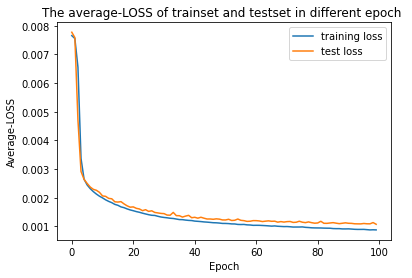

In [389]:
print(test_losses)
print(train_losses)
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='test loss')

plt.xlabel('Epoch')
plt.ylabel('Average-LOSS')
plt.title('The average-LOSS of trainset and testset in different epoch ')
plt.legend()

"""显示每一类预测的准确率"""
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for (images, labels) in testloader:
        outputs = model(images)# 输出
        _, predicted = torch.max(outputs, 1)# 获取每一行最大值的索引
        c = (predicted == labels).squeeze()# squeeze()去掉0维【默认】，unsqueeze()增加一维
        if labels.shape[0] == batch_Size:
            for i in range(batch_Size):
                label = labels[i]# 获取每一个label
                class_correct[label] += c[i].item()# 累计为True的个数
                class_total[label] += 1# 该类总的个数

# 输出正确率
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] // class_total[i]))

Accuracy of T-shirt : 84 %
Accuracy of Trouser : 97 %
Accuracy of Pullover : 82 %
Accuracy of Dress : 91 %
Accuracy of  Coat : 82 %
Accuracy of Sandal : 96 %
Accuracy of Shirt : 64 %
Accuracy of Sneaker : 92 %
Accuracy of   Bag : 97 %
Accuracy of Ankle boot : 96 %


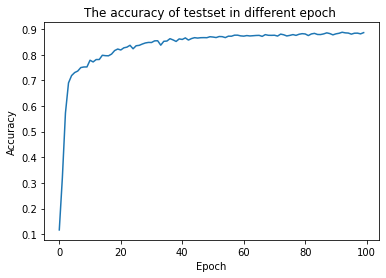

In [390]:

%matplotlib inline
plt.plot(acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('The accuracy of testset in different epoch ')


"""显示每一类预测的准确率"""
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for (images, labels) in testloader:
        outputs = model(images)# 输出
        _, predicted = torch.max(outputs, 1)# 获取每一行最大值的索引
        c = (predicted == labels).squeeze()# squeeze()去掉0维【默认】，unsqueeze()增加一维
        if labels.shape[0] == batch_Size:
            for i in range(batch_Size):
                label = labels[i]# 获取每一个label
                class_correct[label] += c[i].item()# 累计为True的个数
                class_total[label] += 1# 该类总的个数

# 输出正确率
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] // class_total[i]))

100%|██████████| 34/34 [00:01<00:00, 25.74it/s]


[[842.   1.  15.  17.   2.   0. 151.   0.   5.   0.]
 [  0. 973.   2.   6.   1.   0.   1.   0.   1.   0.]
 [ 17.   2. 822.  18.  61.   0.  83.   0.   3.   0.]
 [ 36.  17.  12. 914.  38.   1.  32.   0.   2.   0.]
 [  4.   2.  75.  24. 829.   0.  75.   0.   5.   0.]
 [  1.   1.   1.   0.   0. 970.   0.  22.   1.   9.]
 [ 90.   3.  71.  19.  67.   0. 645.   0.   5.   0.]
 [  0.   0.   0.   0.   0.  16.   0. 927.   5.  24.]
 [ 10.   1.   2.   2.   2.   0.  13.   2. 973.   0.]
 [  0.   0.   0.   0.   0.  13.   0.  49.   0. 967.]]


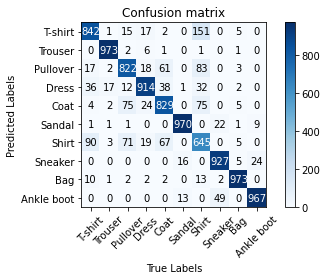

The model accuracy is  0.8862
+------------+-----------+--------+-------------+
|            | Precision | Recall | Specificity |
+------------+-----------+--------+-------------+
|  T-shirt   |   0.815   | 0.842  |    0.979    |
|  Trouser   |   0.989   | 0.973  |    0.999    |
|  Pullover  |   0.817   | 0.822  |     0.98    |
|   Dress    |   0.869   | 0.914  |    0.985    |
|    Coat    |   0.818   | 0.829  |    0.979    |
|   Sandal   |   0.965   |  0.97  |    0.996    |
|   Shirt    |   0.717   | 0.645  |    0.972    |
|  Sneaker   |   0.954   | 0.927  |    0.995    |
|    Bag     |   0.968   | 0.973  |    0.996    |
| Ankle boot |    0.94   | 0.967  |    0.993    |
+------------+-----------+--------+-------------+


In [391]:
import torch
from torchvision import transforms, datasets
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from prettytable import PrettyTable

class ConfusionMatrix(object):
    """
    注意，如果显示的图像不全，是matplotlib版本问题
    本例程使用matplotlib-3.2.1(windows and ubuntu)绘制正常
    需要额外安装prettytable库
    """
    def __init__(self, num_classes: int, labels: list):
        self.matrix = np.zeros((num_classes, num_classes))
        self.num_classes = num_classes
        self.labels = labels

    def update(self, preds, labels):
        for p, t in zip(preds, labels):
            self.matrix[p, t] += 1

    def summary(self):
        # calculate accuracy
        sum_TP = 0
        for i in range(self.num_classes):
            sum_TP += self.matrix[i, i]
        acc = sum_TP / np.sum(self.matrix)
        print("The model accuracy is ", acc)

        # precision, recall, specificity
        table = PrettyTable()
        table.field_names = ["", "Precision", "Recall", "Specificity"]
        for i in range(self.num_classes):
            TP = self.matrix[i, i]
            FP = np.sum(self.matrix[i, :]) - TP
            FN = np.sum(self.matrix[:, i]) - TP
            TN = np.sum(self.matrix) - TP - FP - FN
            Precision = round(TP / (TP + FP), 3) if TP + FP != 0 else 0.
            Recall = round(TP / (TP + FN), 3) if TP + FN != 0 else 0.
            Specificity = round(TN / (TN + FP), 3) if TN + FP != 0 else 0.
            table.add_row([self.labels[i], Precision, Recall, Specificity])
        print(table)
        return table

    def plot(self):
        matrix = self.matrix
        print(matrix)
        plt.imshow(matrix, cmap=plt.cm.Blues)

        # 设置x轴坐标label
        plt.xticks(range(self.num_classes), self.labels, rotation=45)
        # 设置y轴坐标label
        plt.yticks(range(self.num_classes), self.labels)
        # 显示colorbar
        plt.colorbar()
        plt.xlabel('True Labels')
        plt.ylabel('Predicted Labels')
        plt.title('Confusion matrix')

        # 在图中标注数量/概率信息
        thresh = matrix.max() / 2
        for x in range(self.num_classes):
            for y in range(self.num_classes):
                # 注意这里的matrix[y, x]不是matrix[x, y]
                info = int(matrix[y, x])
                plt.text(x, y, info,
                         verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if info > thresh else "black")
        plt.tight_layout()
        plt.show()


if __name__ == '__main__':

    confusion = ConfusionMatrix(num_classes=10, labels=classes)
    net.eval()
    with torch.no_grad():
        for val_data in tqdm(testloader):
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            outputs = torch.softmax(outputs, dim=1)
            outputs = torch.argmax(outputs, dim=1)
            confusion.update(outputs.to("cpu").numpy(), val_labels.to("cpu").numpy())
    confusion.plot()
    confusion.summary()

score_array: (10000, 10)
label_onehot: (10000, 10)


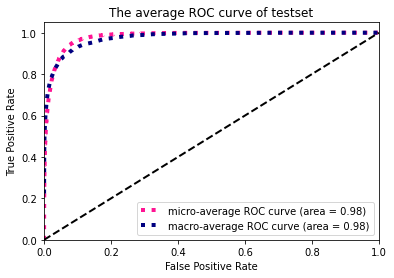

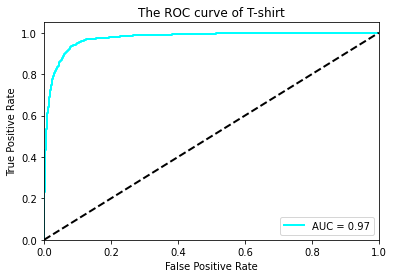

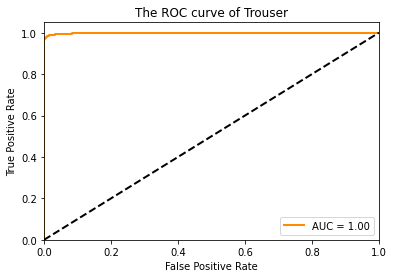

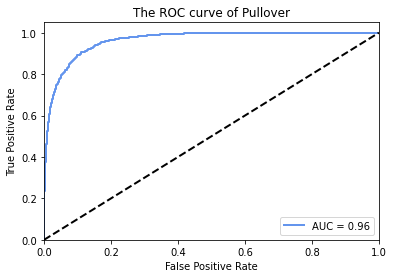

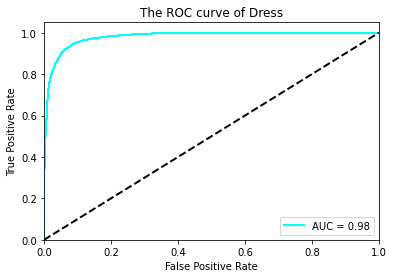

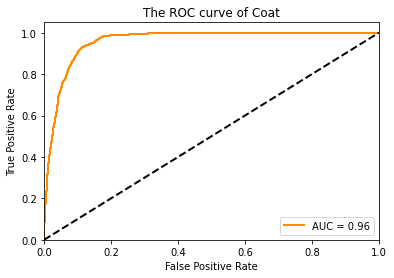

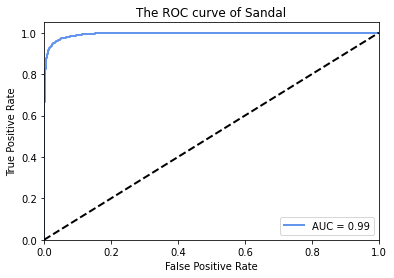

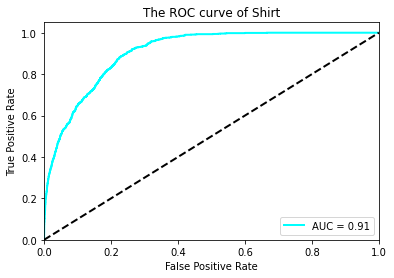

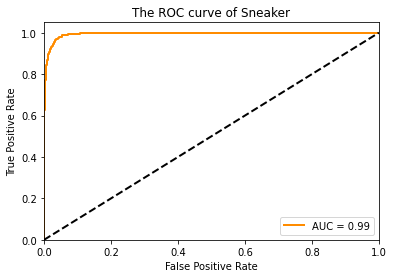

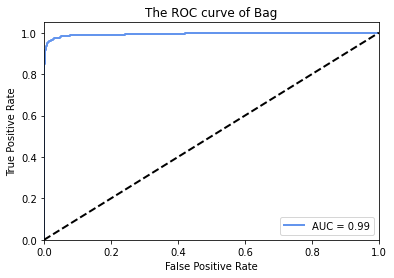

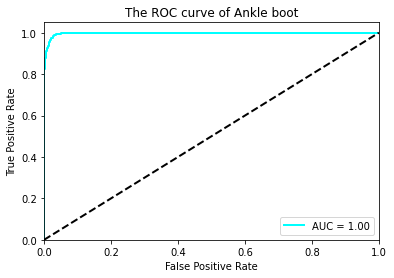

In [392]:
import os
import numpy as np
from torchvision.datasets import ImageFolder
# from utils.transform import get_transform_for_test
# from senet.se_resnet import FineTuneSEResnet50
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

num_class = 10
score_array = np.array(score_list)
# 将label转换成onehot形式
label_tensor = torch.tensor(label_list)
label_tensor = label_tensor.reshape((label_tensor.shape[0], 1))
label_onehot = torch.zeros(label_tensor.shape[0], num_class)
label_onehot.scatter_(dim=1, index=label_tensor, value=1)
label_onehot = np.array(label_onehot)
 
print("score_array:", score_array.shape)  # (batchsize, classnum)
print("label_onehot:", label_onehot.shape)  # torch.Size([batchsize, classnum])
 
# 调用sklearn库，计算每个类别对应的fpr和tpr
fpr_dict = dict()
tpr_dict = dict()
roc_auc_dict = dict()
for i in range(num_class):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(label_onehot[:, i], score_array[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
# micro
fpr_dict["micro"], tpr_dict["micro"], _ = roc_curve(label_onehot.ravel(), score_array.ravel())
roc_auc_dict["micro"] = auc(fpr_dict["micro"], tpr_dict["micro"])
 
# macro
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(num_class)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_class):
    mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
# Finally average it and compute AUC
mean_tpr /= num_class
fpr_dict["macro"] = all_fpr
tpr_dict["macro"] = mean_tpr
roc_auc_dict["macro"] = auc(fpr_dict["macro"], tpr_dict["macro"])
 
# 绘制所有类别平均的roc曲线
plt.figure()
lw = 2
plt.plot(fpr_dict["micro"], tpr_dict["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc_dict["micro"]),
            color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr_dict["macro"], tpr_dict["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc_dict["macro"]),
            color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(num_class), colors):
#     plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=lw,
#                 label='ROC curve of class {0} (area = {1:0.2f})'
#                     ''.format(i, roc_auc_dict[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The average ROC curve of testset')
plt.legend(loc="lower right")
# plt.savefig('set113_roc.jpg')
plt.show()

for i, color in zip(range(num_class), colors):
    plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=lw,
                label='AUC = {0:0.2f}'
                    ''.format(roc_auc_dict[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('The ROC curve of {0}'.format(classes[i]))
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
print(score_list)
print(label_list)